In [1]:
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')

import main
drive_path = r"U:\VEIDB/"
data_path = r"V:\Data"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import numpy as np
from scipy.signal import convolve, medfilt
from scipy import ndimage
import pandas as pd
from pathlib import Path
from matplotlib.gridspec import GridSpec
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('white')

In [3]:
# Import local Neuron project
import sys
projects_folder = r'C:\Users\bramn\Documents\Projects'
if os.path.abspath(projects_folder) not in sys.path:
    sys.path.append(os.path.abspath(projects_folder))

import Neuron
from Neuron.datatypes.block import Block
from Neuron.visualization import spikes as vis_spikes
from ephys.neuropixels_utils import get_ap_analog
from Neuron.stages import stage
from Neuron.stages.pipeline import Pipeline
from Neuron.stages.firing_rate_estimation import FiringRateEstimation
from Neuron.stages.downsampling import Downsampling

In [4]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()
lfp_table = ft.ephys_tables.LFP()
opto_table = ft.event_tables.OptoEvents()

In [5]:
""" Parameters """
key = {'experiment_id': '01589', 'session_id': '20211022', 'subsession_type': 'SWEP'}
# key = {'experiment_id': '01231', 'session_id': '20211020', 'subsession_type': 'EXPA'}

sSC_surface = 2100
stims_vis = ['EXBA', 'DIBM', 'EXBW', 'SWEP', 'CHPE']
# stims_vis = ['CHPE', 'EXPA', 'DIMM', 'CHPE', 'SWEP']


figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images", f"neurons_{key['experiment_id']}_{key['session_id']}")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)


In [6]:
import random
color_palette = sb.color_palette("tab10")
#sns.color_palette("hls", 5)
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [7]:
unit_info, units = (subsess_spikes_table & key).fetch1('cluster_info', 'clusters')
block = Block(units_dict=units, unit_info=unit_info).annot_slice(annot='good')
block.remap_depth(sSC_surface, reverse=False)

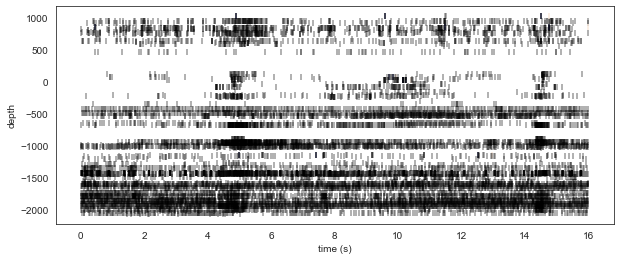

In [8]:
fig, ax = plt.subplots(figsize=(10, 4))
vis_spikes.plot_raster(block.time_slice(0, 1000*16), ax, visualize_depth=True)
plt.show()

In [9]:
# [(c, d) for c, d in cluster_info['depth'].items() if c in clusters_good and d < 2200 and d > 1900]

## Basic stats

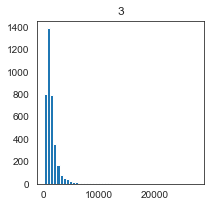

In [10]:
for u_id, unit in block.units.items():
    u_spikes = unit.views['spikes']
    isis = np.diff(unit.views['spikes'])
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.hist(isis, bins=50)
    ax.set_title(u_id)
    plt.show()
    break

# Plot all neurons

In [11]:
from scipy import ndimage

def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

In [12]:
""" Load all data """
hz = 40
sigma = 30*100

stims_dict = {}
for stim in stims_vis:
    print(stim)
    stims_dict[stim] = {}
    stims_dict[stim]['key'] = {'subsession_type': stim, 'experiment_id': key['experiment_id'], 'session_id': key['session_id']}
    unit_info, units = (subsess_spikes_table & stims_dict[stim]['key']).fetch('cluster_info', 'clusters')
    unit_info, units = unit_info[-1], units[-1]
    block = Block(units_dict=units, unit_info=unit_info)
    starts, ends, triggers = (subsess_events_table & stims_dict[stim]['key']).fetch('trials_starts', 'trials_ends', 'subsession_triggers')
    stims_dict[stim]['starts'], stims_dict[stim]['ends'], stims_dict[stim]['triggers'] = starts[-1], ends[-1], triggers[-1]
    stims_dict[stim]['blocks'] = []
    for start, end in zip(stims_dict[stim]['starts'][:10], stims_dict[stim]['ends'][:10]):
        print((end-start)/30000)
        sub_block = block.time_slice(start/30-1000, end/30+1000)
        line = Pipeline()
        line.add_stage(FiringRateEstimation(fr_type='causal'), sigma=sigma, hz=hz) # 30*25 ==> hz=40
        fr = line.execute(sub_block.get_view('spikes'), meta=None)[-1]
        sub_block.add_view('fr', fr, hz=hz)
        stims_dict[stim]['blocks'].append(sub_block)

EXBA
1.9997666666666667


C:\Users\bramn\Documents\Projects\Neuron\datatypes\block.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.squeeze(np.array(view))


[159]
1.9999666666666667
[159]
1.9999666666666667
[159]
2.0
[159]
1.9999666666666667
[159]
2.0000333333333336
[159]
1.9999333333333333
[159]
2.0001333333333333
[159]
1.9999333333333333
[159]
1.9999666666666667
[159]
DIBM
1.9998666666666667


C:\Users\bramn\Documents\Projects\Neuron\datatypes\block.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.squeeze(np.array(view))


[159]
1.9999666666666667
[159]
2.0
[159]
1.9997666666666667
[159]
1.9999666666666667
[159]
2.0
[159]
2.0
[159]
1.9999666666666667
[159]
2.0
[159]
2.0
[159]
EXBW
2.0


C:\Users\bramn\Documents\Projects\Neuron\datatypes\block.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.squeeze(np.array(view))


[159]
2.0
[159]
2.0006666666666666
[160]
1.9997666666666667
[159]
1.9999666666666667
[159]
1.9997666666666667
[159]
2.0002
[159]
2.0
[159]
2.0
[159]
1.9999666666666667
[159]
SWEP
2.956566666666667


C:\Users\bramn\Documents\Projects\Neuron\datatypes\block.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.squeeze(np.array(view))


[198]
7.1006
[363]
2.9571666666666667
[198]
2.956733333333333
[198]
2.9582
[198]
7.100533333333333
[363]
7.100933333333334
[364]
2.9572
[198]
2.9572666666666665
[198]
7.0988
[363]
CHPE
32.0835


C:\Users\bramn\Documents\Projects\Neuron\datatypes\block.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.squeeze(np.array(view))


[1363]
32.08316666666666
[1363]
32.083333333333336
[1363]
32.08316666666666
[1363]
32.082966666666664
[1363]
32.08316666666666
[1363]
32.083133333333336
[1363]
32.08316666666666
[1363]
32.08316666666666
[1363]
32.083333333333336
[1363]


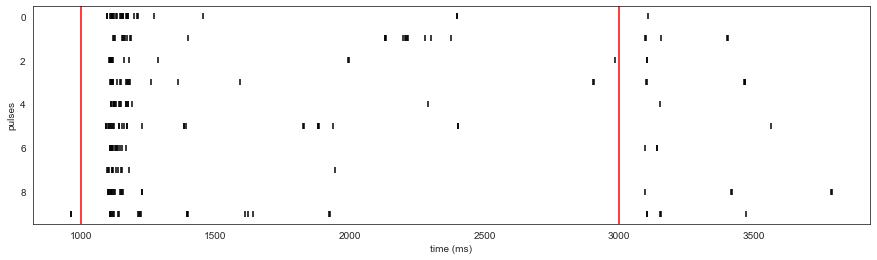

In [13]:

fig, axs = plt.subplots(1, 1, figsize=(15, 4))

unit = block[u_id]
for i, subblock in enumerate(stims_dict['EXBA']['blocks']):
    pulse_spikes = subblock[170].views['spikes'].astype('uint32')
#         print(unit.views['spikes'][-1], start)
#     pulse_spikes = unit.time_slice(start/30, start/30+10).views['spikes'].astype('uint32')
    axs.scatter(np.array(pulse_spikes)/30, np.ones_like(pulse_spikes)*i, marker='|', c=[(0, 0, 0, 1)])
axs.set(xlabel='time (ms)', ylabel='pulses')
axs.axvline(1000, c='r')
axs.axvline(3*1000, c='r')
plt.gca().invert_yaxis()
# plt.savefig(os.path.join(unit_path, f'rasterplot_{u_id}.svg'), dpi=200)
plt.show()


170
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(120,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(119,)
(158,)
(323,)
(158,)
(158,)
(158,)
(323,)
(324,)
(158,)
(158,)
(323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)
(1323,)


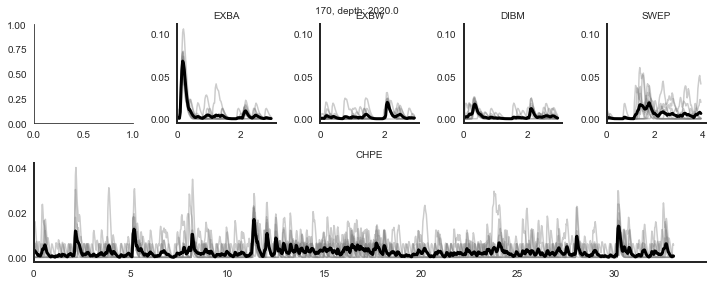

In [15]:
padding = 30000*(0.1)
binsize = 50
smooth_sigma = 3
n_trials = 5
bins_per_sec = 1000/hz
plt.rcParams.update({'font.family': 'Arial'})

widths = [1, 1, 1, 1, 1]
cmap_viridis = matplotlib.cm.get_cmap('viridis')
# print(cmap.colors)
# cmap.colors = cmap.colors[len(cmap.colors)//2:]

cmap = matplotlib.colors.ListedColormap(cmap_viridis.colors[::2], name='myColorMap', N=len(cmap_viridis.colors)//2)


for u_id, unit in stims_dict['EXBA']['blocks'][0].units.items():
    if u_id != 170:
        continue
    print(u_id)
    u_depth = unit.unit_info['depth']
    
    fig = plt.figure(constrained_layout=False, figsize=(10, 4))
    gs = GridSpec(2, 5, figure=fig, width_ratios=widths)
    spike_raster_ax = fig.add_subplot(gs[0, 0])
    stims_dict['EXBA']['ax'] = fig.add_subplot(gs[0,1])
    stims_dict['EXBW']['ax'] = fig.add_subplot(gs[0,2], sharey=stims_dict['EXBA']['ax'])
    stims_dict['DIBM']['ax'] = fig.add_subplot(gs[0,3], sharey=stims_dict['EXBA']['ax'])
    stims_dict['SWEP']['ax'] = fig.add_subplot(gs[0,4], sharey=stims_dict['EXBA']['ax'])
    stims_dict['CHPE']['ax'] = fig.add_subplot(gs[1,:])#, sharey=stims_dict['EXBA']['ax'])
    fig.suptitle(f"{u_id}, depth: {u_depth}", fontsize=10)
    
    for stim, d in stims_dict.items():
        trials = []
        trial_lengths = []
#         curr_block = d['block'][u_id]
        for sub_block in d['blocks']:
            fr = np.squeeze(sub_block[u_id].views['fr'])[1*hz:]
#             trials.append(fr)
            print(fr.shape)
            trials.append(fr)
#             trials.append(smooth_spikecounts(fr, sigma=smooth_sigma))
            trial_lengths.append(len(fr))
        
        min_trial_length = min(trial_lengths)
        stims_dict[stim]['trials'] = trials
        stims_dict[stim]['min_trial_length'] = min_trial_length
        stims_dict[stim]['trials_np'] = np.array([trial[:min_trial_length] for trial in trials]) # Assumes that all trials have the same length!!

    
    """ Visualization """
    for idx, (stim, d) in enumerate(stims_dict.items()):
        trials_np = d['trials_np']
        n_trials = len(trials_np)
        for i, trial in enumerate(trials_np[:n_trials]):
            n_trials = len(trials_np)
            d['ax'].plot(np.arange(0, len(trial))/hz, trial*bins_per_sec, c='gray', alpha=0.4)#, alpha=(((n_trials)-i)/n_trials)/3 + 1/3)

        d['ax'].set_title(stim, fontsize=10)
        mean_response = np.mean(trials_np[:n_trials], axis=0)*bins_per_sec
        d['ax'].plot(np.arange(0, len(mean_response))/hz, mean_response, c='k', alpha=1, linewidth=3)
        d['ax'].spines['top'].set_visible(False)
        d['ax'].spines['right'].set_visible(False)
        d['ax'].set(xlim=[0,None])
#         d['ax'].set(xticks=[0, 2, 4])
#         d['ax'].axvspan(0, 1, alpha=0.1, color='royalblue')
#         d['ax'].tick_params(axis='x', length=3*sc, width=1*sc, pad=3*sc)
#         d['ax'].tick_params(axis='y', length=3*sc, width=1*sc, pad=3*sc)
        for axis in ['top', 'bottom', 'left', 'right']:
            d['ax'].spines[axis].set_linewidth(2)

#         d['ax'].axvline((padding/(30000)), c='r', alpha=1, linewidth=1)
#         d['ax'].axvline((len(trials_np[0]) - (padding/(binsize*30)))*binsize/1000, c='r', alpha=1, linewidth=1) # slightly incorrect since trials might have been shortened

    sb.despine(trim=False)

    plt.tight_layout()
#     plt.savefig(os.path.join(figures_folder, f"{u_depth}_{u_id}.svg"), dpi=100)

    plt.show()

In [24]:
# padding = 30000*(0.1)
# binsize = 25
# smooth_sigma = 1
# n_trials = 4 
# bins_per_sec = 1000/binsize
# plt.rcParams.update({'font.family': 'Arial'})

# widths = [1, 1, 1, 1, 1]
# cmap_viridis = matplotlib.cm.get_cmap('viridis')
# # print(cmap.colors)
# # cmap.colors = cmap.colors[len(cmap.colors)//2:]

# cmap = matplotlib.colors.ListedColormap(cmap_viridis.colors[::2], name='myColorMap', N=len(cmap_viridis.colors)//2)


# for u_id, unit in stims_dict['EXBA']['blocks'].units.items():
#     print(u_id)
#     u_depth = unit.unit_info['depth']
    
#     fig = plt.figure(constrained_layout=False, figsize=(10, 4))
#     gs = GridSpec(2, 5, figure=fig, width_ratios=widths)
#     spike_raster_ax = fig.add_subplot(gs[0, 0])
#     stims_dict['EXBA']['ax'] = fig.add_subplot(gs[0,1])
#     stims_dict['EXBW']['ax'] = fig.add_subplot(gs[0,2], sharey=stims_dict['EXPA']['ax'])
#     stims_dict['DIBM']['ax'] = fig.add_subplot(gs[0,3], sharey=stims_dict['EXPA']['ax'])
#     stims_dict['SWBP']['ax'] = fig.add_subplot(gs[0,4], sharey=stims_dict['EXPA']['ax'])
#     stims_dict['CHPE']['ax'] = fig.add_subplot(gs[1,:], sharey=stims_dict['EXPA']['ax'])
#     fig.suptitle(f"{u_id}, depth: {u_depth}", fontsize=10)
    
#     for stim, d in stims_dict.items():
#         trials = []
#         trial_lengths = []
#         curr_block = d['block'][u_id]
#         for start, end in zip(d['starts'], d['ends']):
#             fr = curr_block.time_slice(start/30, end/30).views['fr']
# #             spikecounts = spikes_2_spikecounts({u_id: d['clusters'].get(u_id, np.array([]))}, start=start-padding, end=end+padding, binsize=binsize)[u_id]
# #             trials.append(smooth_spikecounts(spikecounts, sigma=smooth_sigma))
#             trials.append(fr)
#             trial_lengths.append(len(fr))
#         min_trial_length = min(trial_lengths)
#         stims_dict[stim]['trials'] = trials
#         stims_dict[stim]['min_trial_length'] = min_trial_length
#         stims_dict[stim]['trials_np'] = np.array([trial[:min_trial_length] for trial in trials]) # Assumes that all trials have the same length!!

    
#     """ Visualization """
#     for idx, (stim, d) in enumerate(stims_dict.items()):
#         trials_np = d['trials_np']
#         n_trials = len(trials_np)
#         for i, trial in enumerate(trials_np[:n_trials]):
#             n_trials = len(trials_np)
#             d['ax'].plot(np.arange(0, len(trial))*binsize/1000, trial*bins_per_sec, c='gray', alpha=0.4)#, alpha=(((n_trials)-i)/n_trials)/3 + 1/3)

#         d['ax'].set_title(stim, fontsize=10)
#         mean_response = np.mean(trials_np[:n_trials], axis=0)*bins_per_sec
#         d['ax'].plot(np.arange(0, len(mean_response))*binsize/1000, mean_response, c='k', alpha=1, linewidth=3)
#         d['ax'].spines['top'].set_visible(False)
#         d['ax'].spines['right'].set_visible(False)
#         d['ax'].set(xlim=[0,None])
# #         d['ax'].set(xticks=[0, 2, 4])
# #         d['ax'].axvspan(0, 1, alpha=0.1, color='royalblue')
# #         d['ax'].tick_params(axis='x', length=3*sc, width=1*sc, pad=3*sc)
# #         d['ax'].tick_params(axis='y', length=3*sc, width=1*sc, pad=3*sc)
#         for axis in ['top', 'bottom', 'left', 'right']:
#             d['ax'].spines[axis].set_linewidth(2)

# #         d['ax'].axvline((padding/(30000)), c='r', alpha=1, linewidth=1)
# #         d['ax'].axvline((len(trials_np[0]) - (padding/(binsize*30)))*binsize/1000, c='r', alpha=1, linewidth=1) # slightly incorrect since trials might have been shortened

#     sb.despine(trim=False)

#     plt.tight_layout()
# #     plt.savefig(os.path.join(figures_folder, "extra", f"{c_depth}_{c}.png"), dpi=100)

#     plt.show()

KeyError: 'block'

## Convert to firing rates

Instantaneous firing rates vs spike counts?


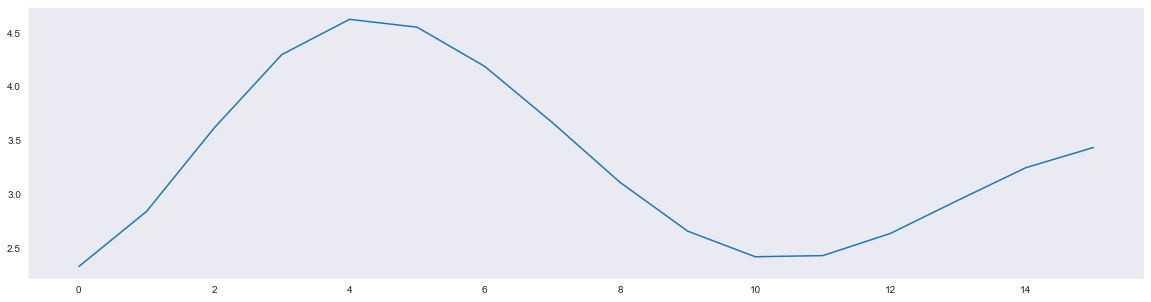

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(smooth_spikecounts(spikecounts[120], sigma=2))
plt.show()

In [118]:
fr_matrix = np.zeros(shape=(len(spikecounts), len(spikecounts[0])))
fr_matrix_meta = {}
for i, (c, spikecount) in enumerate(spikecounts.items()):
    fr_matrix[i] = spikecount#smooth_spikecounts(spikecount, sigma=2)
    fr_matrix_meta[c] = i

In [119]:
fr_matrix = (fr_matrix.T - np.mean(fr_matrix.T, axis=0)).T

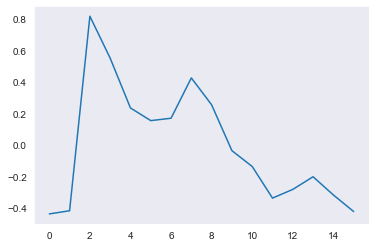

In [120]:
plt.plot(np.mean(fr_matrix, axis=0))

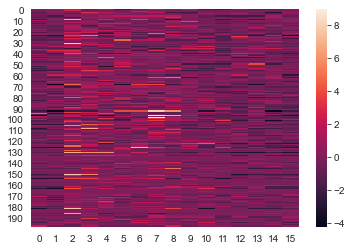

In [121]:
sb.heatmap(fr_matrix)
plt.show()

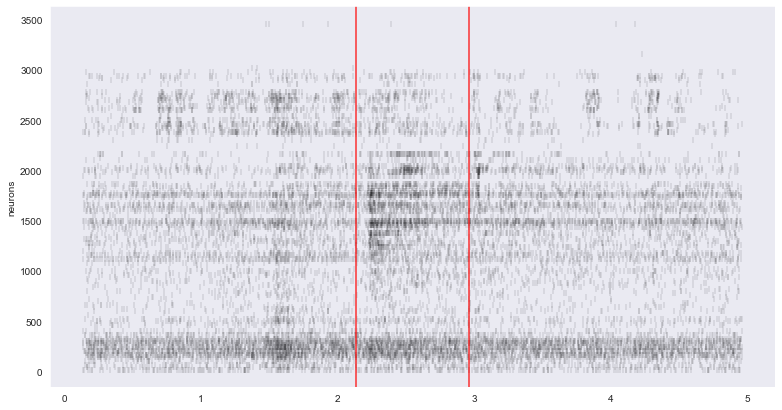

In [59]:
fig, ax = plt.subplots(figsize=(13, 7))
plot_spike_raster(clusters_good, start=63941-60000, end=88940+60000, ax=ax, event_times=[(0,63941), (1,88940)], colored=False, color_palette=color_palette, visualize_depth=True, cluster_depths=cluster_info['depth'])
plt.show()

## Clustering

Find paper that does this kind of clustering! Check retina research + Karl's paper

In [47]:
fr_matrix.shape

(199, 16)

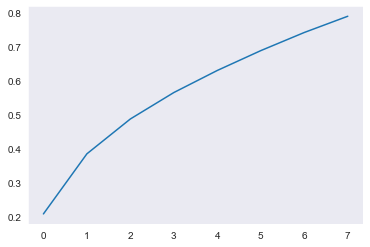

In [50]:
""" Perform PCA on spikes"""
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=8)
pca.fit(fr_matrix)
embeddings = pca.transform(fr_matrix)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [51]:
fr_matrix_reduc = pca.transform(fr_matrix)

In [52]:
fr_matrix_recon = pca.inverse_transform(fr_matrix_reduc)

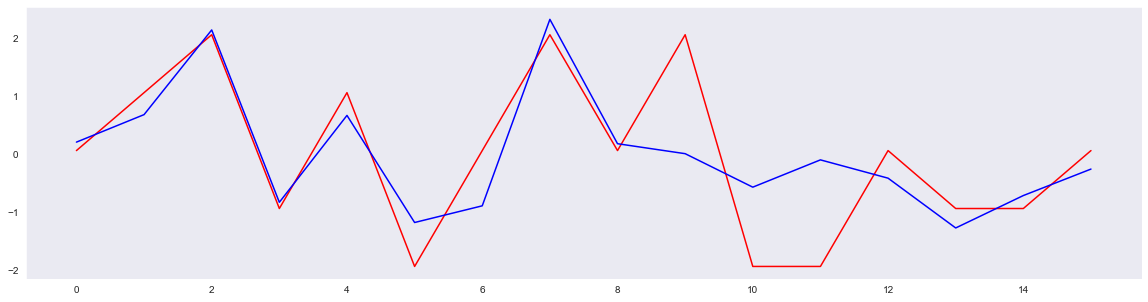

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(fr_matrix[0], c='r')
ax.plot(fr_matrix_recon[0], c='b')
plt.show()

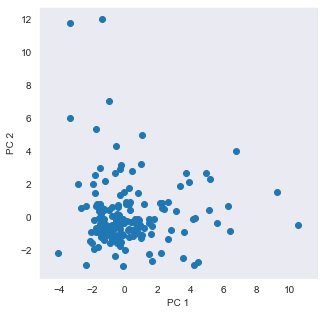

In [54]:
""" 2d plot"""
plt.figure(figsize=(5, 5))
plt.scatter(
    fr_matrix_reduc[:, 0],
    fr_matrix_reduc[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
# plt.savefig('SC_PCA_trialavg_ssc.png', dpi=100)
plt.show()

In [55]:
import umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(fr_matrix_reduc)


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


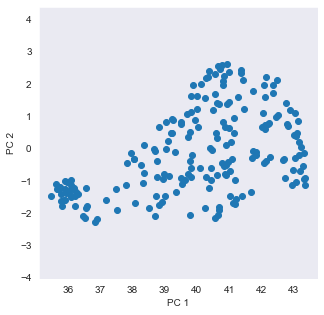

In [56]:
""" 2d plot"""
plt.figure(figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.gca().set_aspect('equal', 'datalim')
# plt.title('PCA of mouse SC activity during looming stimuli', fontsize=14)
# plt.savefig('SC_PCA_trialavg_ssc.png', dpi=100)
plt.show()

In [ ]:
# ELBOW method for deciding K in K-means
import sklearn.cluster

ssqs = []
for k in range(1, 15):
    kmeans = sklearn.cluster.KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    kmeans.fit(embeddings)
    ssqs.append(kmeans.inertia_)
    
plt.plot(ssqs)

# ----------OLD----------

In [60]:
""" Check with all spiking data"""
spike_times, spike_clusters, cluster_info = (sorted_table & {'experiment_id': '01247', 'session_id': '20200328e'}).fetch1('spike_times', 'spike_clusters', 'cluster_info')

data = {}
for cluster in np.unique(spike_clusters):
    if cluster_info['group'][cluster] == 'good':# or cluster_info['group'][cluster] == 'mua':
        cl_spike_times = np.squeeze(spike_times[spike_clusters == cluster])
        data[cluster] = cl_spike_times

In [61]:
(subsess_events_table & {'experiment_id': '01247', 'session_id': '20200328e', 'subsession_type': 'OPTS'}).fetch('start_abs', 'trials_starts')

[array([0], dtype=int64),
 array([list([721334, 1322000, 1922665, 2523330, 3123995, 3724661, 4325326, 4925991, 5526656, 6127321, 6727987, 7328652, 7929317, 8529983, 9130648, 9731313, 10331978, 10932643, 11533309, 12133974, 12734639, 13335304, 13935969, 14536634, 15137299, 15737965, 16338630, 16939295, 17539960, 18140625])],
       dtype=object)]

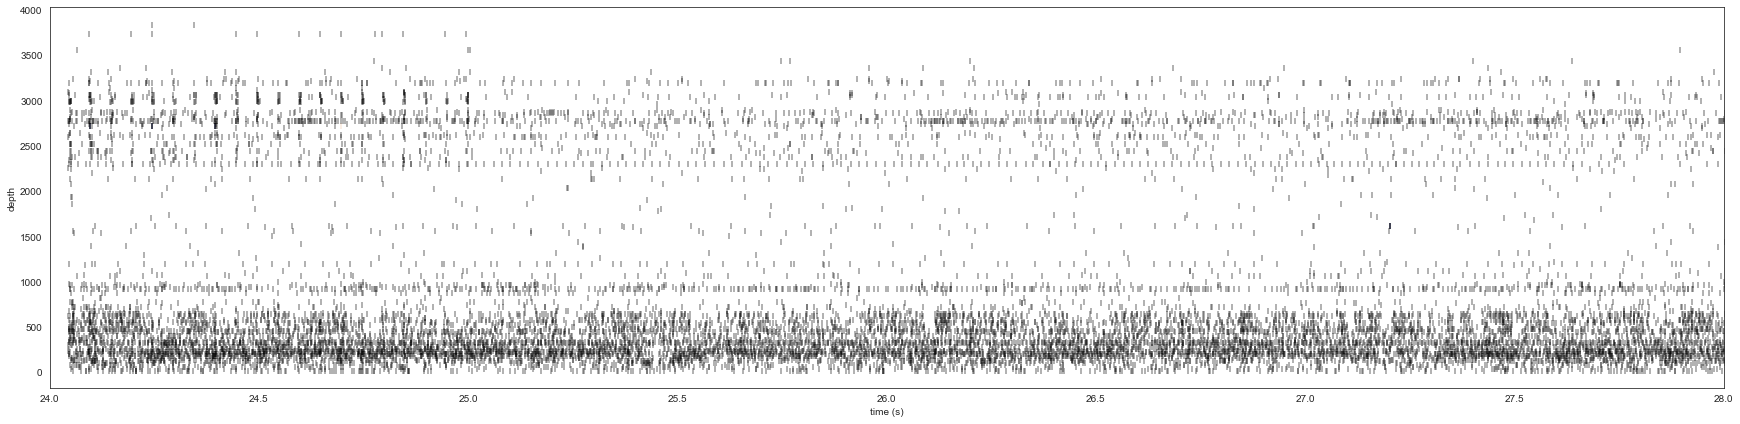

In [62]:
#9960960

fig, ax = plt.subplots(figsize=(30, 7))
plot_spike_raster(data, start=721334, end=721334+30000*10, ax=ax, event_times=None, colored=False, visualize_depth=True, cluster_depths=cluster_info['depth'])
# for trigger in subsess_triggers[7]:
#     ax.axvline((18157956+trigger)/30000, c='r')
# plt.savefig('SC_EXPA.png', dpi=200)
# plt.ylim(2000, 2600)
# plt.xlim(24, 28)
plt.show()

# OLD

In [67]:
def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))
